In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from operator import itemgetter
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial import distance_matrix
import json
import os
from skimage import io, color, transform
%matplotlib notebook

In [2]:
raw = load_wine()
raw_df = pd.DataFrame(data=raw["data"], columns=raw["feature_names"])

In [3]:
raw_df.shape

(178, 13)

In [4]:
raw_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [5]:
import plotly.express as px

fig = px.parallel_coordinates(raw_df,
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

ModuleNotFoundError: No module named 'plotly'

In [6]:
FIG_SIZE = (18,14)

def min_max_scale_df(df):
    scaler = MinMaxScaler()
    scaler.fit(df)
    scaled = pd.DataFrame(scaler.transform(df))
    scaled.columns = df.columns
    return scaled

def normalize_df(df):
    scaler = StandardScaler()
    scaler.fit(df)
    scaled = pd.DataFrame(scaler.transform(df))
    scaled.columns = df.columns
    return scaled

def draw_corr_matrix(df):
    corr_matrix = df.corr()
    plt.figure(figsize=FIG_SIZE)
    sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
    plt.show()

def draw_scatter_matrix(df):
    plt.figure(figsize=FIG_SIZE)
    fig = sns.pairplot(data=df)
    plt.show()
    
def draw_scatterplot(x, y, color, x_lab, y_lab, colorbar = True):
    plt.figure(figsize=FIG_SIZE)
    plt.scatter(
        x,
        y,
        s=100,
        c=color,
        alpha=0.8,
        edgecolor="none",
        cmap=plt.cm.get_cmap('Accent', 20)
    )
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    if colorbar:
        plt.colorbar()

def plot_correlation_circle(df, pca, pcs):
    (fig, ax) = plt.subplots(figsize=FIG_SIZE)
    for i in range(0, len(pca.components_)):
        loading_pc1 = pca.components_[pcs[0], i]
        loading_pc2 = pca.components_[pcs[1], i]
        text = df.columns.values[i]
        ax.arrow(0,0,loading_pc1,loading_pc2)
        plt.text(loading_pc1,loading_pc2,text)
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))
    plt.axis('equal')
    ax.set_title('Correlation Circle')
    plt.xlabel(f"PC{pcs[0]}")
    plt.ylabel(f"PC{pcs[1]}")
    plt.show()

## First some useful stuff

### Scaling

In [7]:
raw_df.var()

alcohol                             0.659062
malic_acid                          1.248015
ash                                 0.075265
alcalinity_of_ash                  11.152686
magnesium                         203.989335
total_phenols                       0.391690
flavanoids                          0.997719
nonflavanoid_phenols                0.015489
proanthocyanins                     0.327595
color_intensity                     5.374449
hue                                 0.052245
od280/od315_of_diluted_wines        0.504086
proline                         99166.717355
dtype: float64

In [8]:
min_max_df = min_max_scale_df(raw_df)
min_max_df.var()

alcohol                         0.045641
malic_acid                      0.048744
ash                             0.021523
alcalinity_of_ash               0.029633
magnesium                       0.024101
total_phenols                   0.046574
flavanoids                      0.044407
nonflavanoid_phenols            0.055139
proanthocyanins                 0.032600
color_intensity                 0.039127
hue                             0.034533
od280/od315_of_diluted_wines    0.067636
proline                         0.050451
dtype: float64

In [9]:
normalized_df = normalize_df(raw_df)
normalized_df.var()

alcohol                         1.00565
malic_acid                      1.00565
ash                             1.00565
alcalinity_of_ash               1.00565
magnesium                       1.00565
total_phenols                   1.00565
flavanoids                      1.00565
nonflavanoid_phenols            1.00565
proanthocyanins                 1.00565
color_intensity                 1.00565
hue                             1.00565
od280/od315_of_diluted_wines    1.00565
proline                         1.00565
dtype: float64

In [10]:
raw_df[["proline", "proanthocyanins"]]

,proline,proanthocyanins
0,1065.0,2.29
1,1050.0,1.28
2,1185.0,2.81
3,1480.0,2.18
4,735.0,1.82
...,...,...
173,740.0,1.06
174,750.0,1.41
175,835.0,1.35
176,840.0,1.46



### Clustering

In [11]:
clusterer = KMeans(n_clusters=3, random_state=0)
labels = clusterer.fit(normalized_df).labels_

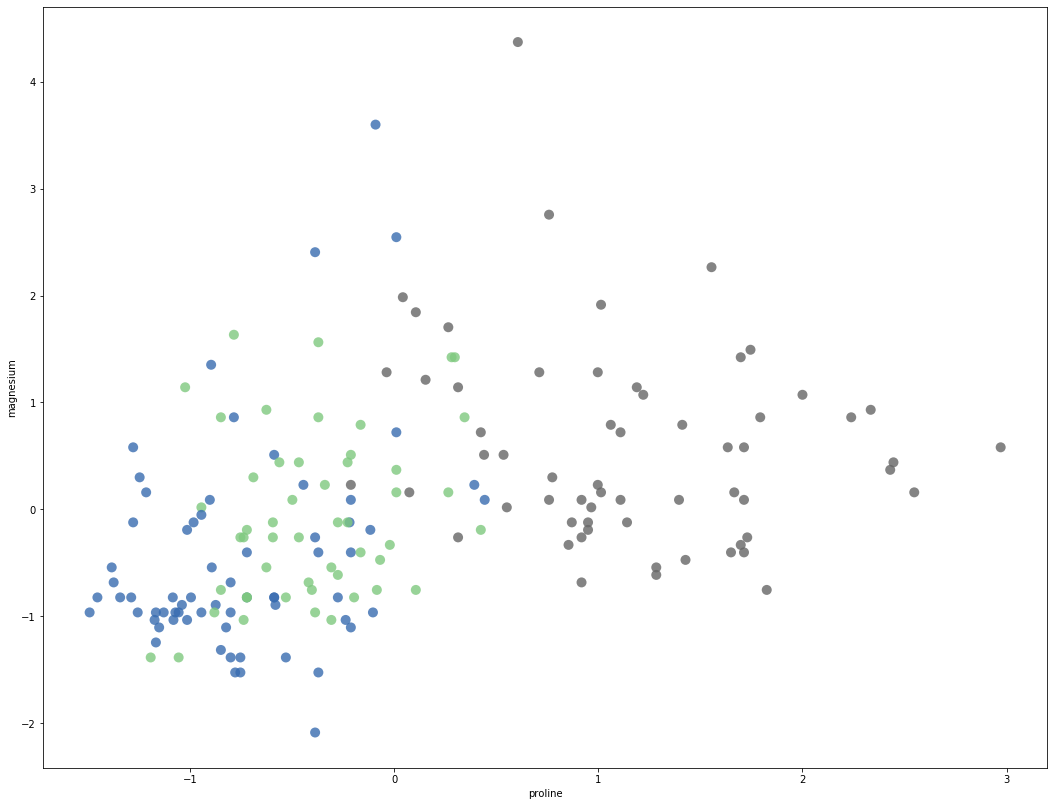

In [12]:
x_axis = "proline"
y_axis = "magnesium"

x = normalized_df[x_axis]
y = normalized_df[y_axis]

draw_scatterplot(x, y, labels, x_axis, y_axis, False)

## Data

<Figure size 1296x1008 with 0 Axes>

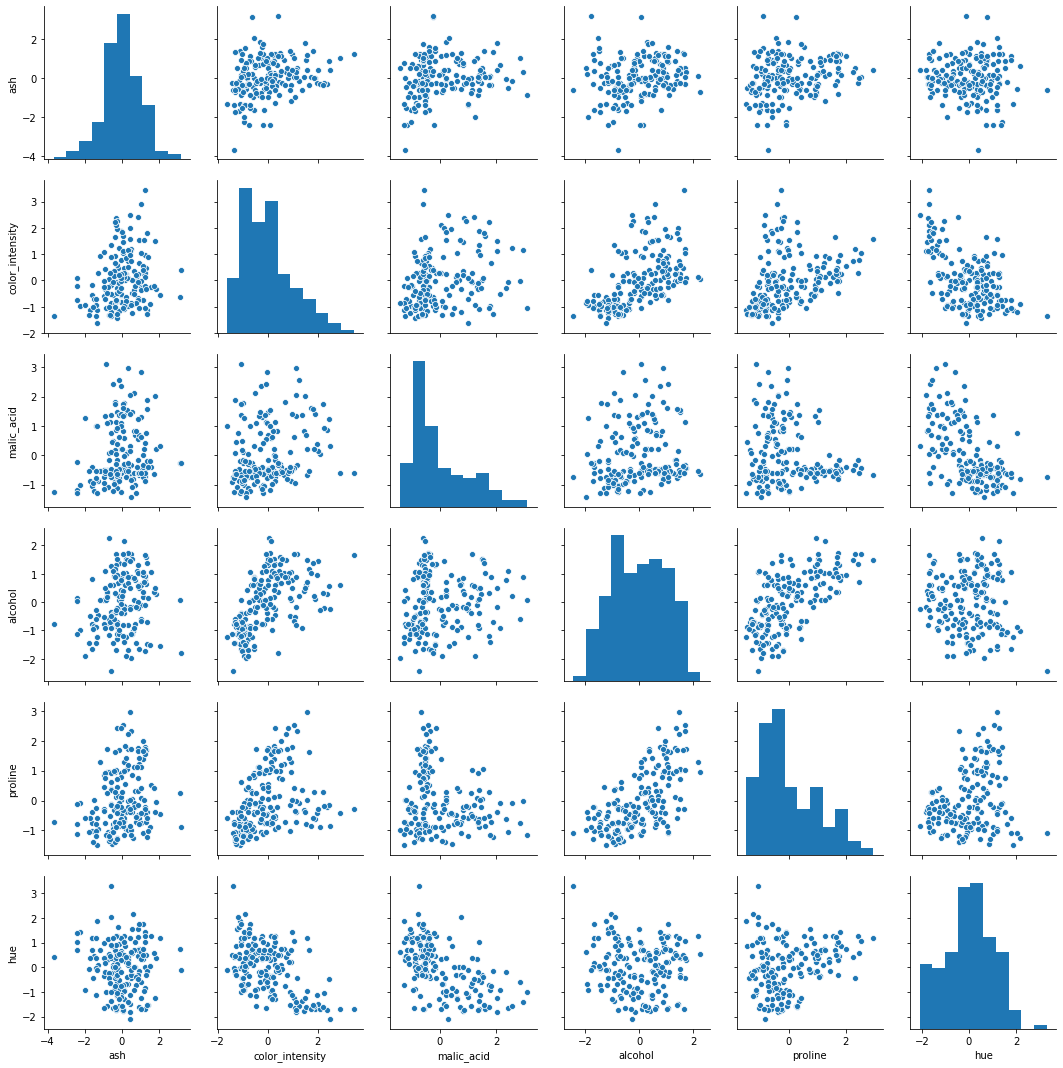

In [13]:
draw_scatter_matrix(normalized_df[["ash", "color_intensity", "malic_acid", "alcohol", "proline", "hue"]])

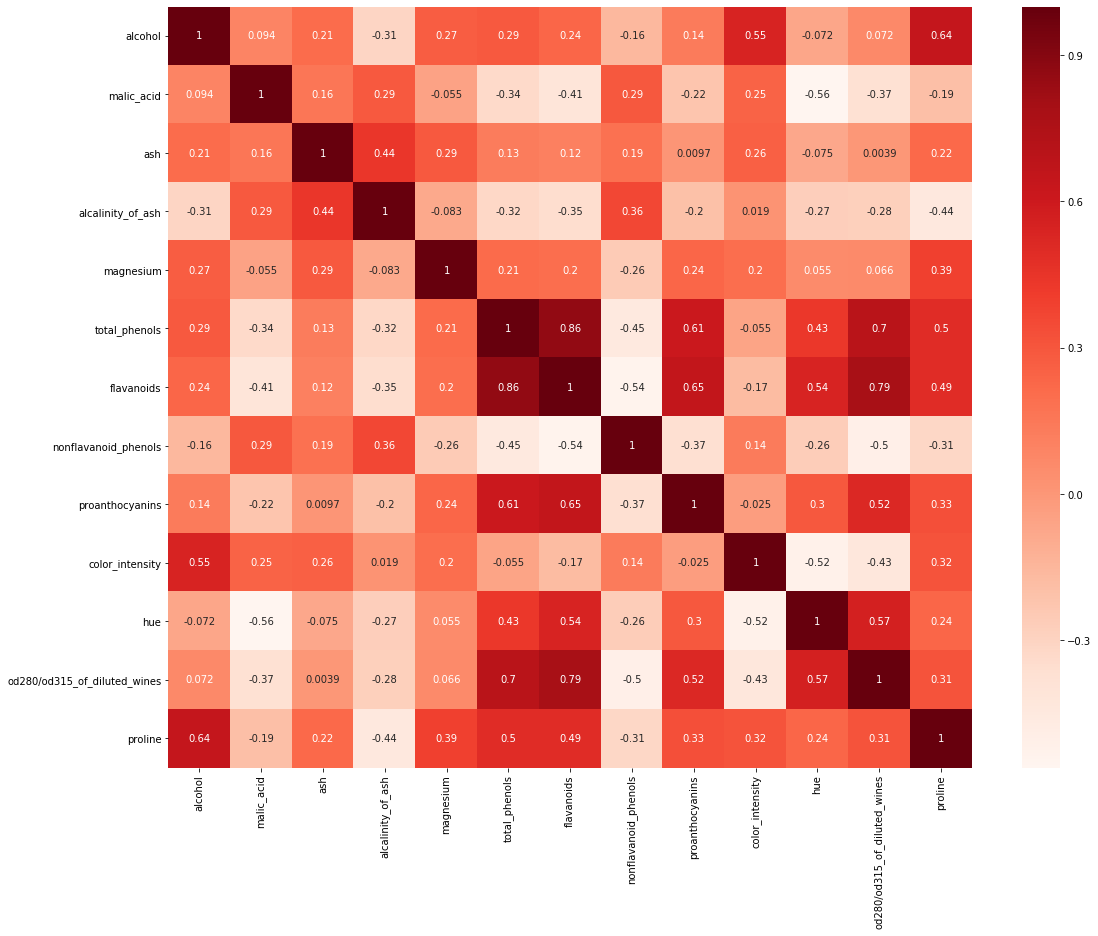

In [15]:
draw_corr_matrix(normalized_df)

## Feature Selection

### Remove highly correlated variables

In [16]:
THRESHOLD = 0.7
corr_matrix = min_max_df.corr()
abs_matrix = corr_matrix.abs()
triangle = abs_matrix.where(np.triu(np.ones(abs_matrix.shape), k=1).astype(np.bool))
triangle

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
alcohol,NaN,0.094397,0.211545,0.310235,0.270798,0.289101,0.236815,0.155929,0.136698,0.546364,0.071747,0.072343,0.643720
malic_acid,NaN,NaN,0.164045,0.288500,0.054575,0.335167,0.411007,0.292977,0.220746,0.248985,0.561296,0.368710,0.192011
ash,NaN,NaN,NaN,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,0.074667,0.003911,0.223626
alcalinity_of_ash,NaN,NaN,NaN,NaN,0.083333,0.321113,0.351370,0.361922,0.197327,0.018732,0.273955,0.276769,0.440597
magnesium,NaN,NaN,NaN,NaN,NaN,0.214401,0.195784,0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
total_phenols,NaN,NaN,NaN,NaN,NaN,NaN,0.864564,0.449935,0.612413,0.055136,0.433681,0.699949,0.498115
flavanoids,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.537900,0.652692,0.172379,0.543479,0.787194,0.494193
nonflavanoid_phenols,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365845,0.139057,0.262640,0.503270,0.311385
proanthocyanins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025250,0.295544,0.519067,0.330417
color_intensity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.521813,0.428815,0.316100


In [17]:
highly_correlated = [column for column in triangle.columns if any(triangle[column] > THRESHOLD)]
highly_correlated

['flavanoids', 'od280/od315_of_diluted_wines']

In [18]:
reducted_df = min_max_df.drop(highly_correlated, axis = 1)
reducted_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.283019,0.593060,0.372014,0.455285,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.245283,0.274448,0.264505,0.463415,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.320755,0.757098,0.375427,0.447154,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.207547,0.558360,0.556314,0.308943,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.490566,0.444795,0.259386,0.455285,0.325963


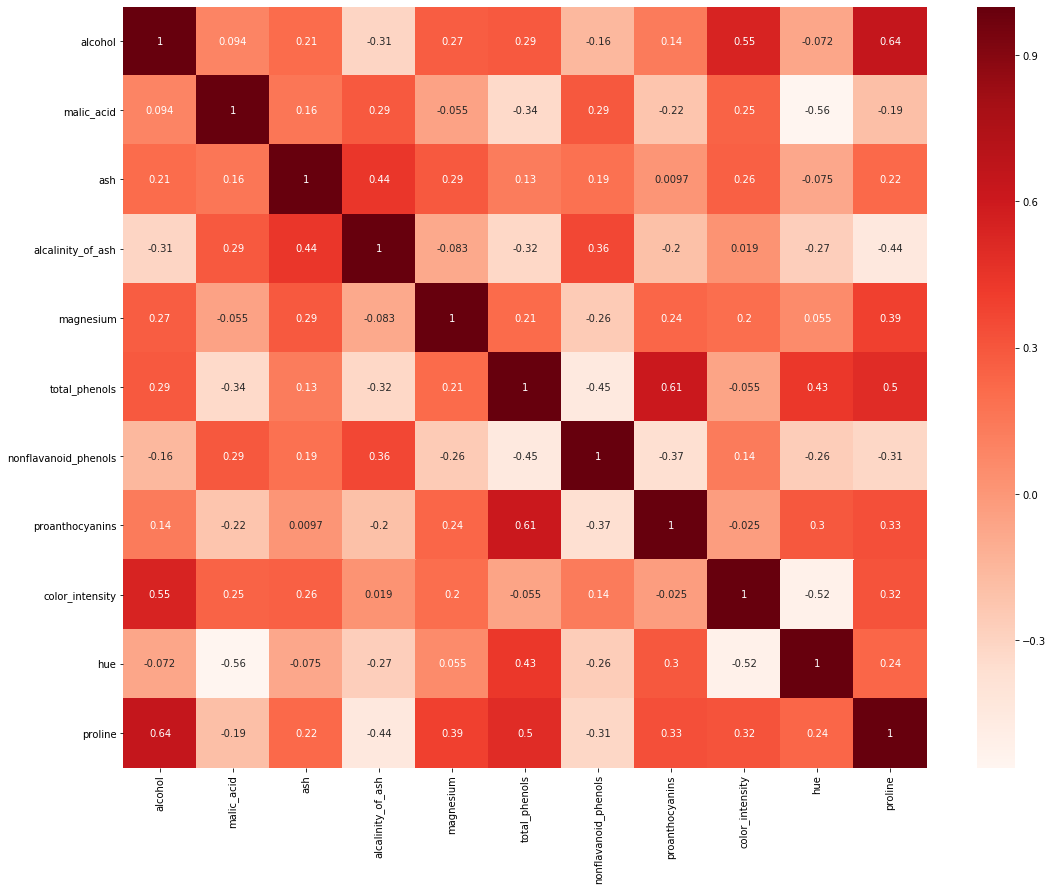

In [19]:
draw_corr_matrix(reducted_df)

### Remove low variance variables

In [20]:
variances = reducted_df.var()

In [21]:
threshold = np.percentile(variances, 10)
threshold

0.024100819395639468

In [22]:
low_variance = [col for col in variances.keys() if variances[col] <= threshold]
low_variance

['ash', 'magnesium']

In [23]:
reducted_df = reducted_df.drop(low_variance, axis=1)

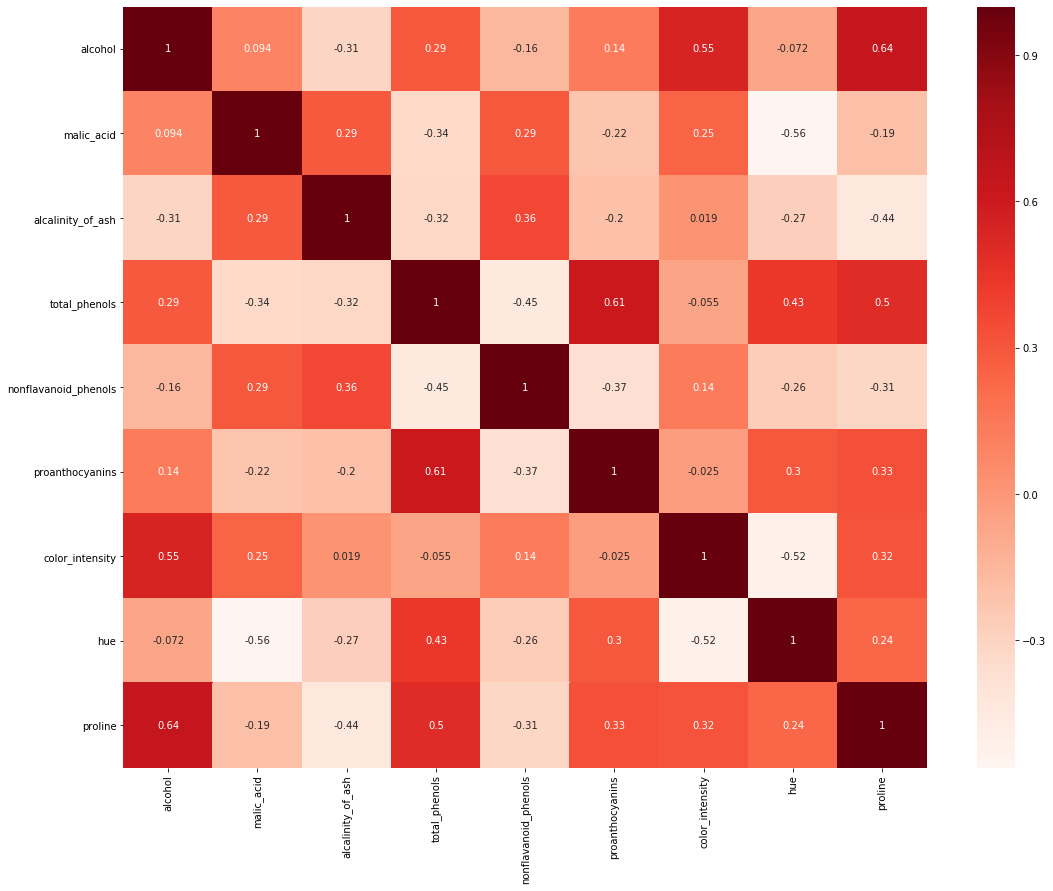

In [24]:
draw_corr_matrix(reducted_df)

## Feature Projection

### PCA

In [25]:
pca = PCA()

In [26]:
pca_rotated = pd.DataFrame(pca.fit_transform(normalized_df))
pca_rotated_arr = pca_rotated.to_numpy()
pca_rotated.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,3.316751,-1.443463,-0.165739,-0.215631,0.693043,-0.223880,0.596427,0.065139,0.641443,1.020956,-0.451563,0.540810,-0.066239
1,2.209465,0.333393,-2.026457,-0.291358,-0.257655,-0.927120,0.053776,1.024416,-0.308847,0.159701,-0.142657,0.388238,0.003637
2,2.516740,-1.031151,0.982819,0.724902,-0.251033,0.549276,0.424205,-0.344216,-1.177834,0.113361,-0.286673,0.000584,0.021717
3,3.757066,-2.756372,-0.176192,0.567983,-0.311842,0.114431,-0.383337,0.643593,0.052544,0.239413,0.759584,-0.242020,-0.369484
4,1.008908,-0.869831,2.026688,-0.409766,0.298458,-0.406520,0.444074,0.416700,0.326819,-0.078366,-0.525945,-0.216664,-0.079364


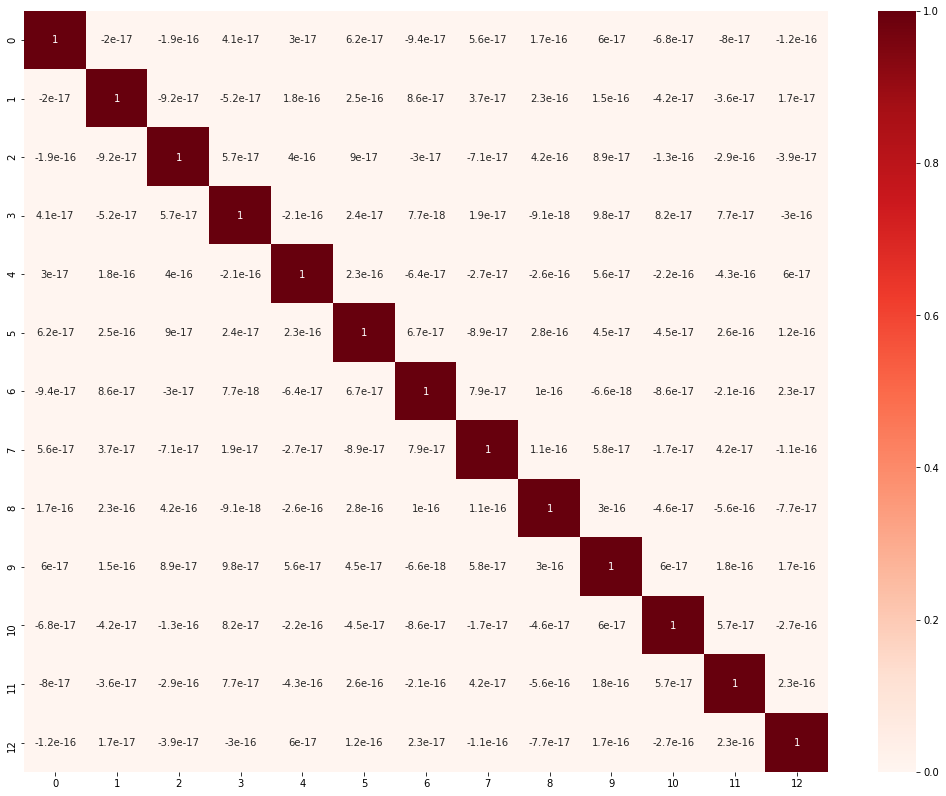

In [27]:
draw_corr_matrix(pca_rotated)

In [28]:
pca.n_components_

13

In [29]:
pca.explained_variance_ratio_

array([0.36198848, 0.1920749 , 0.11123631, 0.0706903 , 0.06563294,
       0.04935823, 0.04238679, 0.02680749, 0.02222153, 0.01930019,
       0.01736836, 0.01298233, 0.00795215])

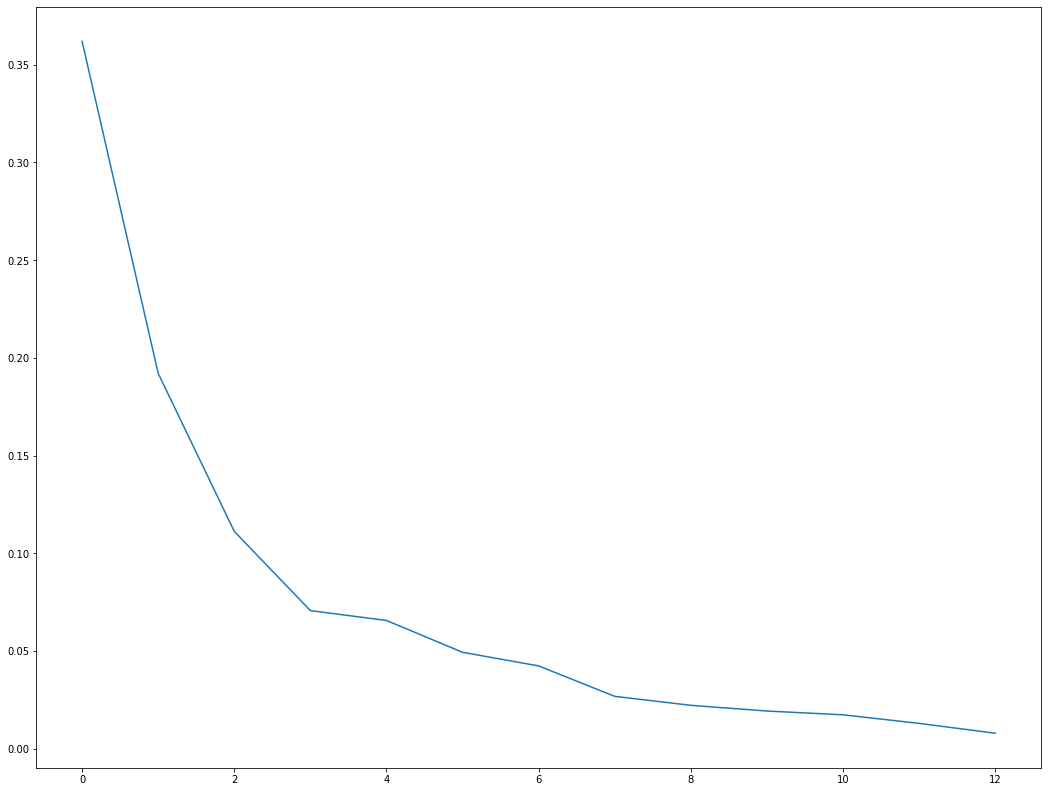

In [30]:
plt.figure(figsize=FIG_SIZE)
plt.plot(pca.explained_variance_ratio_)

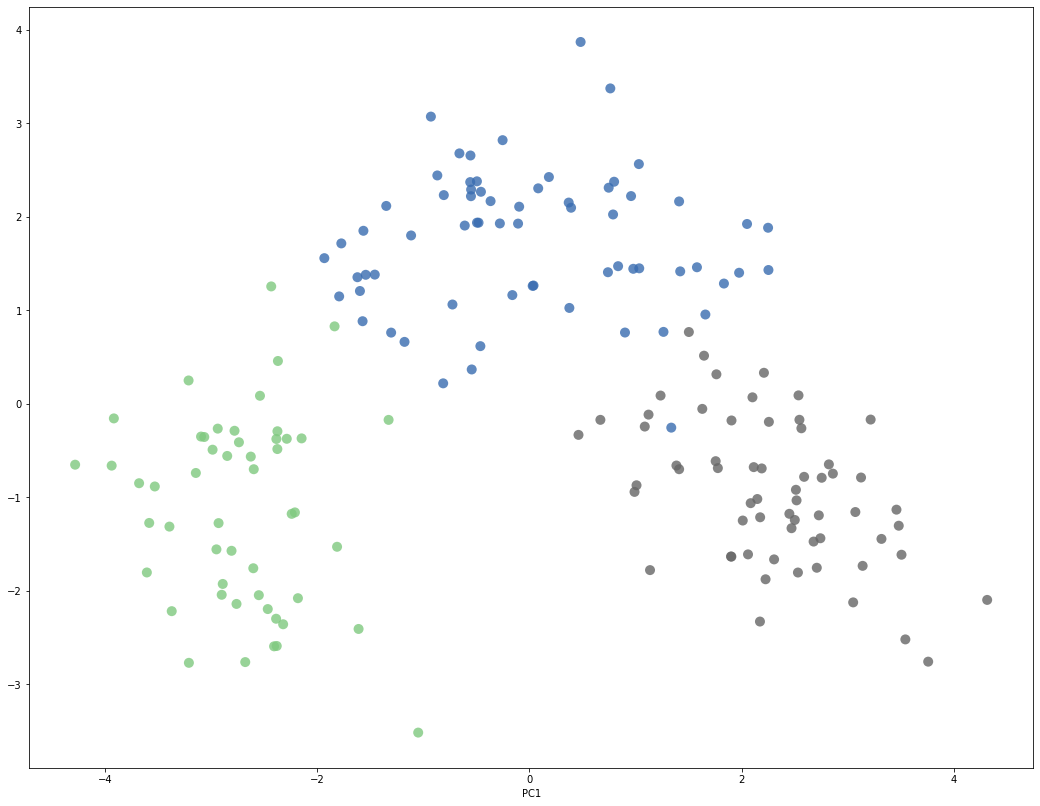

In [31]:
x_axis_pc = 1
y_axis_pc = 2

x = pca_rotated_arr[:, x_axis_pc - 1]
y = pca_rotated_arr[:, y_axis_pc - 1]
color = labels

draw_scatterplot(x, y, color, f"PC{x_axis_pc}", f"", False)

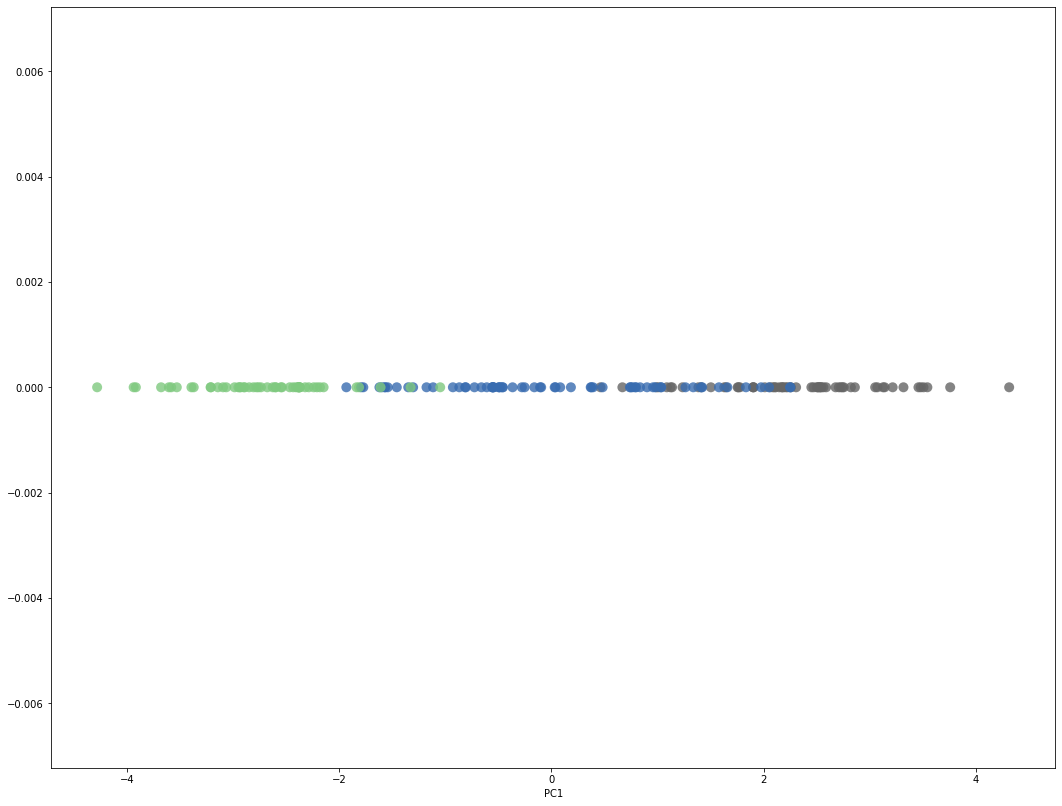

In [32]:
x_axis_pc = 1

x = pca_rotated_arr[:, x_axis_pc - 1]
y = np.zeros_like(x)
color = labels

draw_scatterplot(x, y, color, f"PC{x_axis_pc}", f"", False)

<Figure size 1296x1008 with 0 Axes>

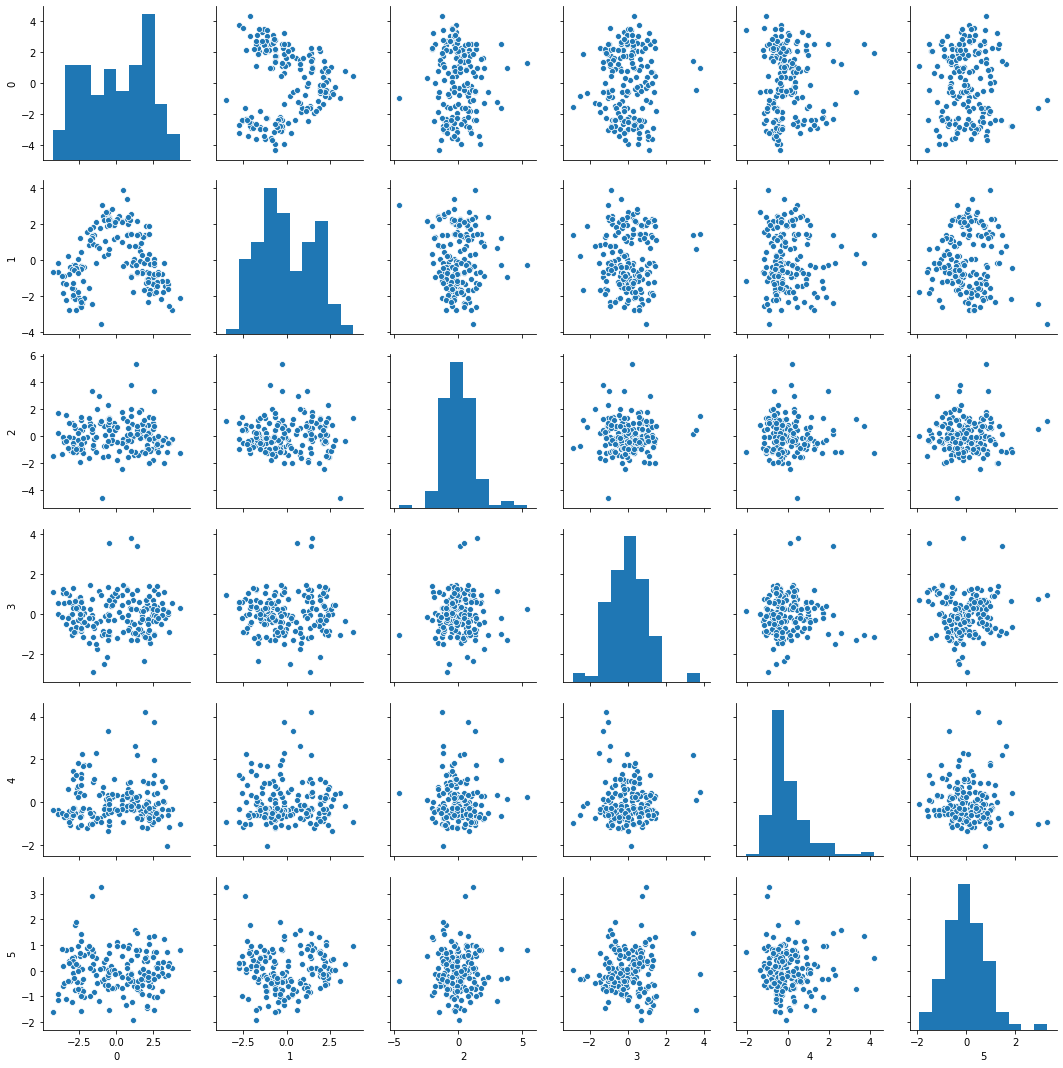

In [52]:
draw_scatter_matrix(pca_rotated[[0,1,2,3,4,5]])

In [33]:
components = list(zip(pca.components_[0], normalized_df.columns))
sorted(components, key=itemgetter(0))

[(-0.2985331029547151, 'nonflavanoid_phenols'),
 (-0.2451875802572206, 'malic_acid'),
 (-0.23932040548753508, 'alcalinity_of_ash'),
 (-0.08861670472472236, 'color_intensity'),
 (-0.0020510614443710606, 'ash'),
 (0.1419920419529872, 'magnesium'),
 (0.1443293954060114, 'alcohol'),
 (0.28675222689680535, 'proline'),
 (0.29671456358638104, 'hue'),
 (0.31342948830768846, 'proanthocyanins'),
 (0.3761674107387125, 'od280/od315_of_diluted_wines'),
 (0.3946608450666301, 'total_phenols'),
 (0.42293429671005905, 'flavanoids')]

In [34]:
components = list(zip(pca.components_[1], normalized_df.columns))
sorted(components, key=itemgetter(0))

[(-0.5299956720700442, 'color_intensity'),
 (-0.48365154781721403, 'alcohol'),
 (-0.3649028317980829, 'proline'),
 (-0.31606881402531584, 'ash'),
 (-0.29963400323786193, 'magnesium'),
 (-0.2249309346278454, 'malic_acid'),
 (-0.06503951181927967, 'total_phenols'),
 (-0.03930172228973278, 'proanthocyanins'),
 (-0.02877948811298668, 'nonflavanoid_phenols'),
 (0.003359812100307613, 'flavanoids'),
 (0.010590502288190778, 'alcalinity_of_ash'),
 (0.1644961928357846, 'od280/od315_of_diluted_wines'),
 (0.279235147924282, 'hue')]

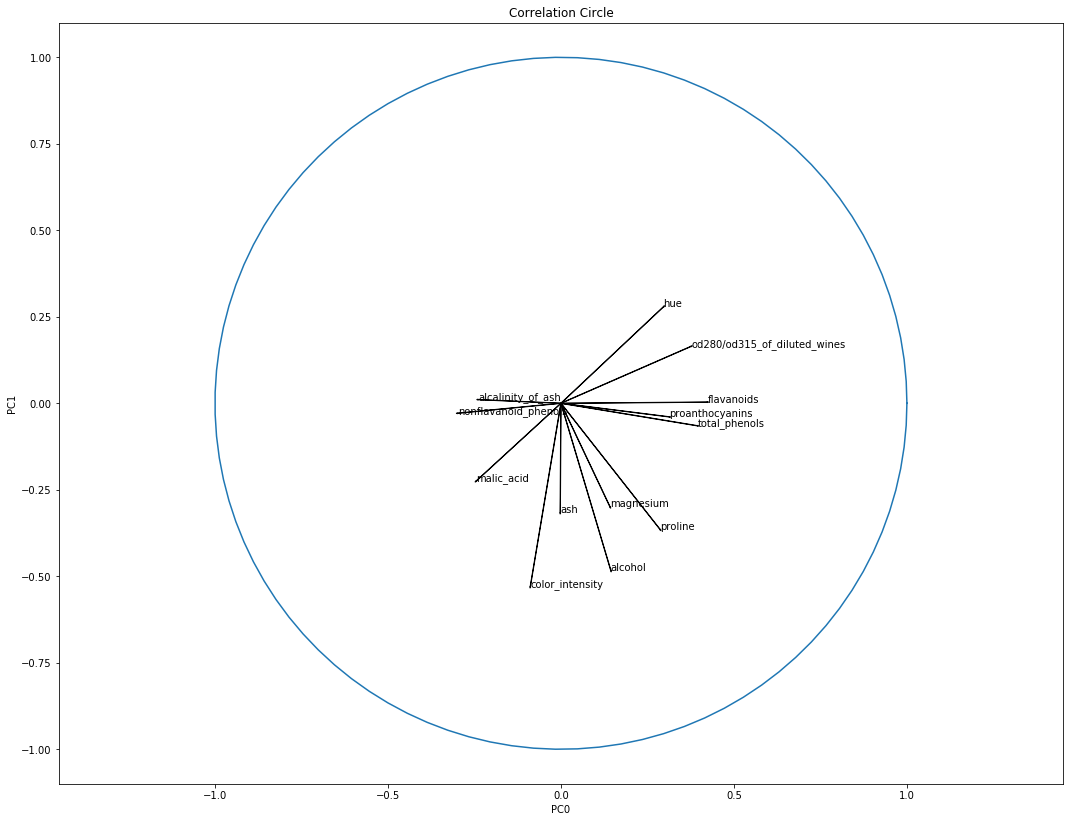

In [35]:
plot_correlation_circle(normalized_df, pca, (0, 1))

### T-SNE

In [36]:
tsne = TSNE(n_components=2)

In [37]:
tsne_rotated = pd.DataFrame(tsne.fit_transform(normalized_df))
tsne_rotated_arr = tsne_rotated.to_numpy()
tsne_rotated.head()

,0,1
0,4.989454,-12.897638
1,3.982899,-8.985863
2,8.369887,-10.034751
3,7.831842,-12.850819
4,8.843850,-5.911789


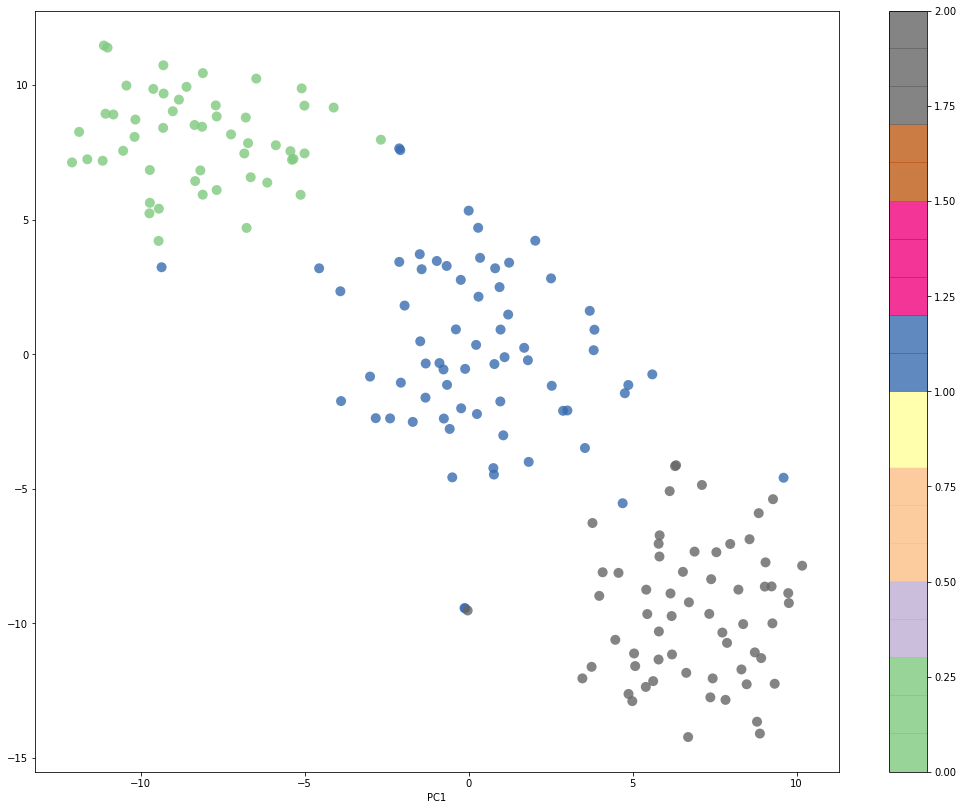

In [38]:
x = tsne_rotated_arr[:, 0]
y = tsne_rotated_arr[:, 1]
color = labels

draw_scatterplot(x, y, color, f"PC{x_axis_pc}", f"")


## Faces

In [39]:
from skimage import io, color, transform

%matplotlib inline
final_shape = (250, 200)
images = []
names = []

for file in os.listdir('./pics'):
    raw_image = io.imread(os.path.join(os.getcwd(), 'pics', file))
    smaller = transform.resize(raw_image, final_shape)
    image = color.rgb2gray(smaller)
    images.append([pixel for row in image for pixel in row])
    names.append(file.split('.')[0])

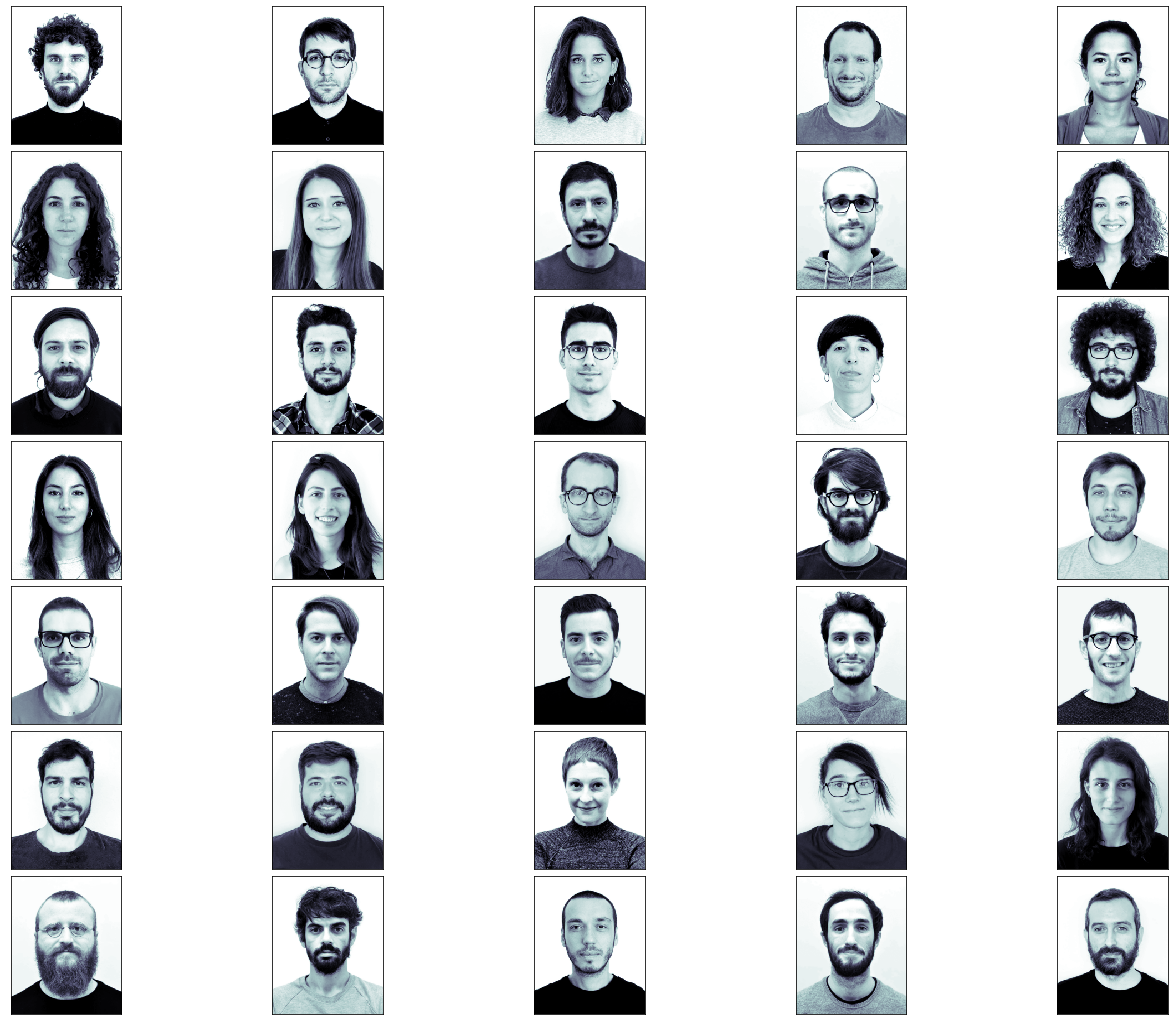

In [40]:
fig = plt.figure(figsize=FIG_SIZE)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(len(images)):
    ax = fig.add_subplot(7, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(images[i], final_shape), cmap=plt.cm.bone, interpolation='nearest')

In [41]:
complete_pca = PCA()
complete_pca.fit(images)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [42]:
complete_pca.explained_variance_ratio_

array([2.37271473e-01, 2.17588761e-01, 1.53439677e-01, 4.46651308e-02,
       4.20472479e-02, 3.67208115e-02, 2.49196565e-02, 2.43384845e-02,
       2.03151678e-02, 1.92985327e-02, 1.59106148e-02, 1.43744193e-02,
       1.31446950e-02, 1.28755578e-02, 1.21150321e-02, 9.93762874e-03,
       9.75833173e-03, 9.26781192e-03, 9.02275200e-03, 8.77760234e-03,
       8.13997636e-03, 6.66312358e-03, 6.21304584e-03, 5.58791651e-03,
       5.20850245e-03, 4.96200426e-03, 4.43852118e-03, 4.04057053e-03,
       3.88128574e-03, 3.78058681e-03, 3.42942231e-03, 2.94835909e-03,
       2.81220509e-03, 2.10509218e-03, 9.14942932e-31])

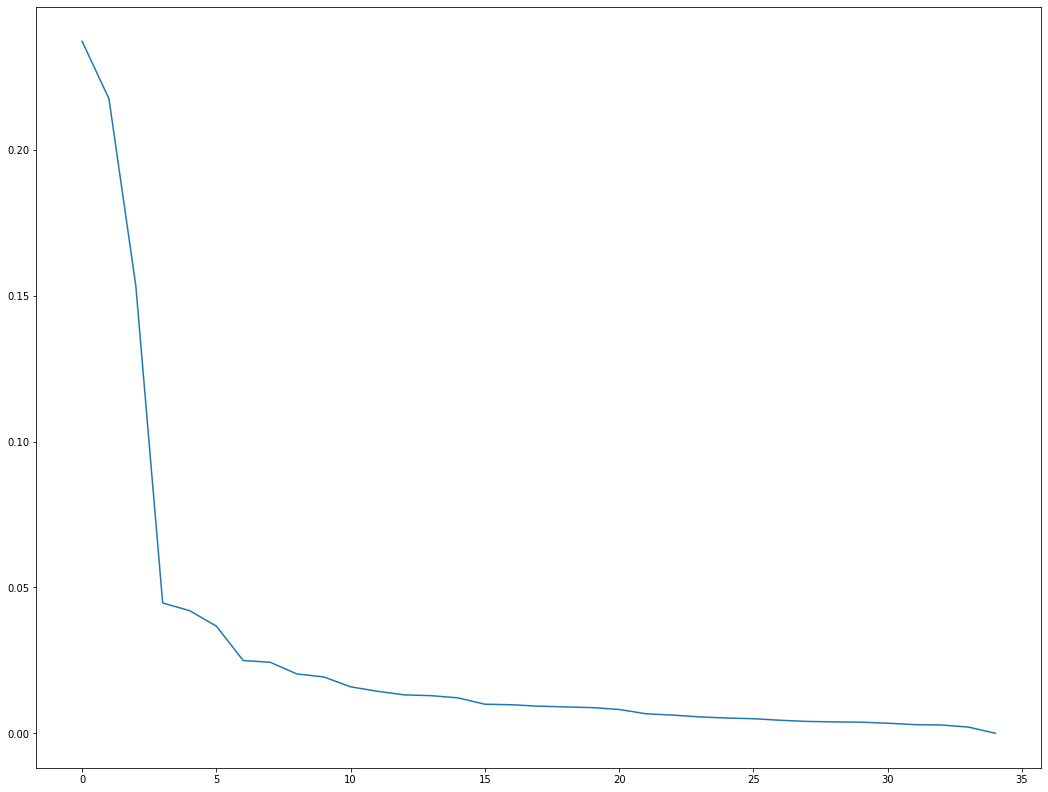

In [43]:
plt.figure(figsize=FIG_SIZE)
plt.plot(complete_pca.explained_variance_ratio_)

In [44]:
def plot_compressed(pcs):
    partial_pca = PCA(pcs)
    images_proj = partial_pca.fit_transform(images)
    if pcs < 1:
        print(partial_pca.explained_variance_ratio_)
    people = { name: image.tolist() for name, image in zip(names, images_proj) }
    reversed_proj = partial_pca.inverse_transform(images_proj)
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(len(reversed_proj)):
        ax = fig.add_subplot(7, 5, i+1, xticks=[], yticks=[])
        ax.imshow(np.reshape(reversed_proj[i], final_shape), cmap=plt.cm.bone, interpolation='nearest')

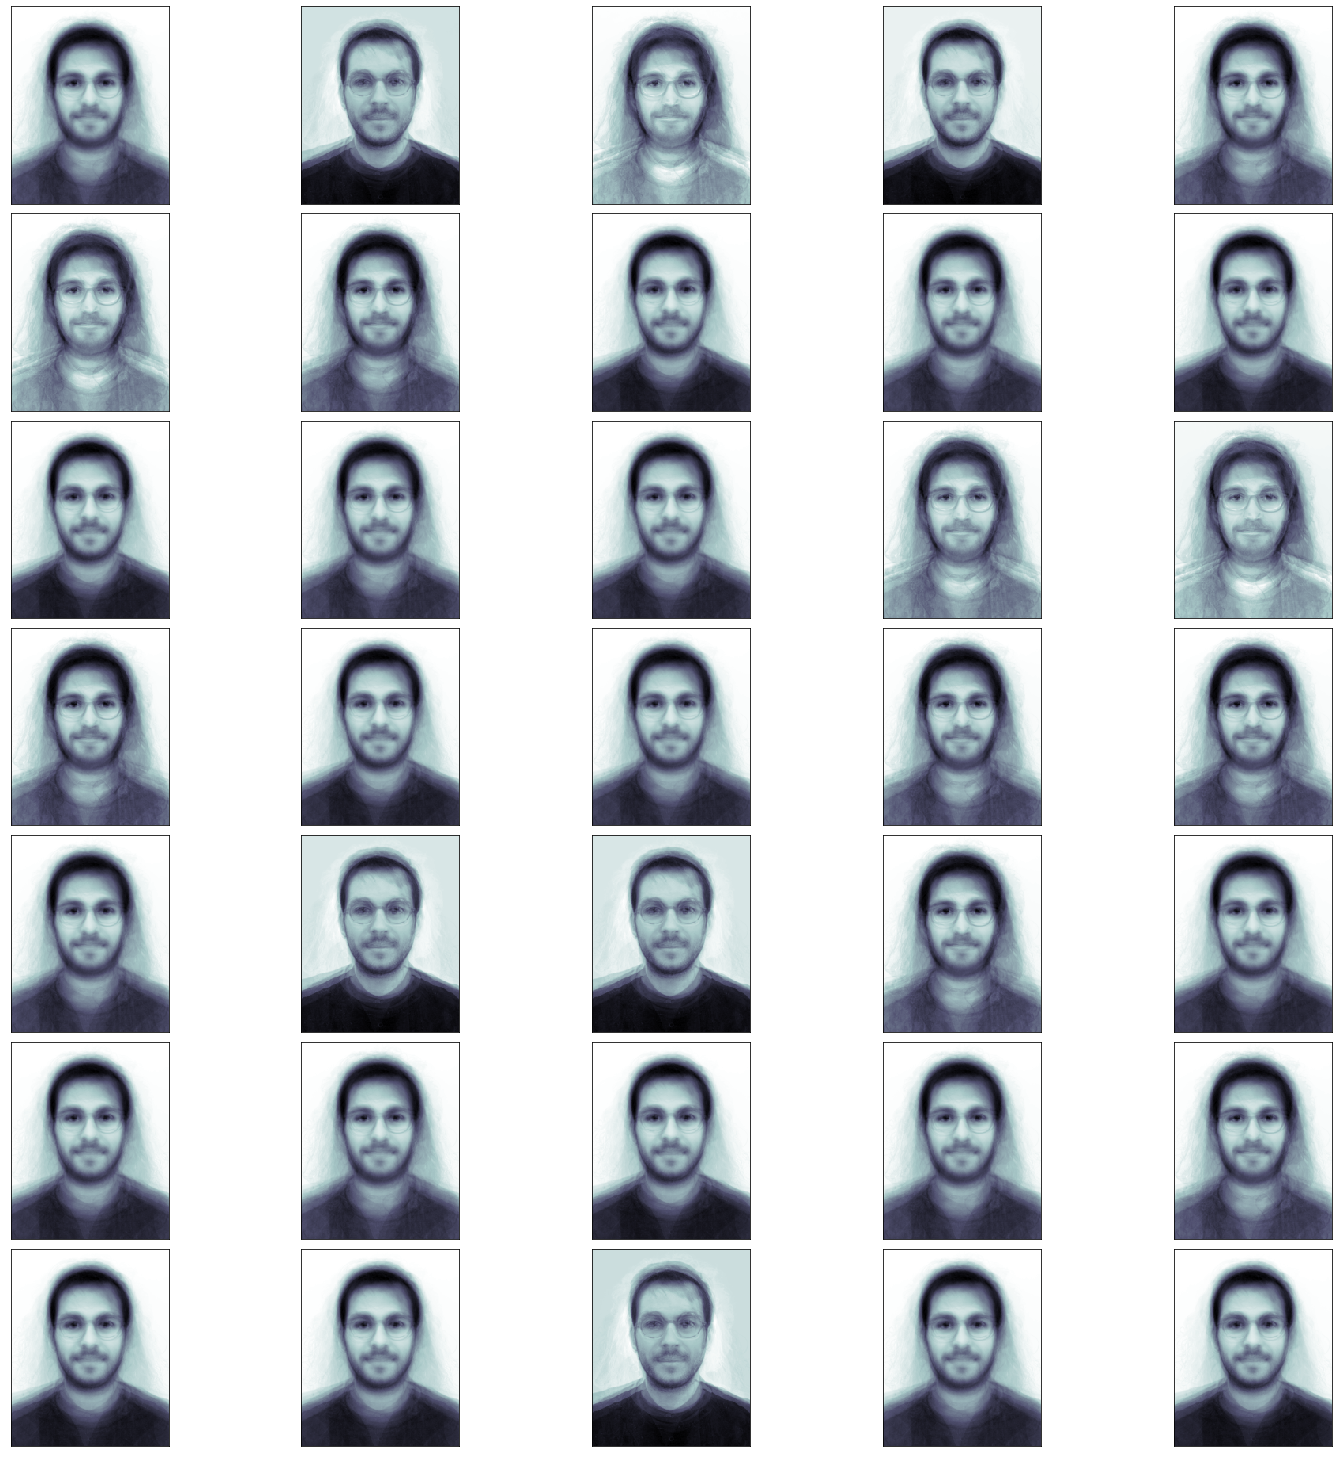

In [53]:
plot_compressed(1)